In [36]:
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from twitter.models import *
import parliament.models as pms

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime

import igraph
#import mpld3

from adjustText import adjust_text

print(igraph.__version__)

0.7.1


In [37]:
def draw_network(ax, g, layout, labels, interactive=False):
    #label_ids = [l['id'] for l in labels]
    x = [x[0] for x in layout]
    y = [x[1] for x in layout]
    c = [v["color"] for v in g.vs if v["color"] is not None]
    
    s = [12 + v["tweets"]*0.15 for v in g.vs]
    lw = [0.1 for v in g.vs ]

    scatter = ax.scatter(x,y,c=c,s=s,edgecolor="black",linewidths=lw)
    

    for e in g.es:#[:1000]:
        s = layout[e.source]
        t = layout[e.target]
        ex = [s[0],t[0]]
        ey = [s[1],t[1]]
        lw = 0.05+(np.log(e['weight']+1)*0.5) #+0.05+(np.log(e['connection_to_n']+1)*5)  #+0.05+np.log(e['connection_to_n'])
        alpha = 0.25
        ax.plot(
            ex,
            ey,
            c="grey",
            lw=lw,
            alpha=alpha,
            zorder=-5
        )    

    texts = []
    for l in labels:
        xy = layout[l["id"]]
        texts.append(ax.text(xy[0],xy[1],l["name"],fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    for text in texts:
        text.set_alpha(0.7)
        
    ax.grid(False)
    ax.axis('off')
    
    if interactive:
        tooltip =  mpld3.plugins.PointLabelTooltip(
            scatter, 
            labels=[x for x in g.vs["twitter-name"] if x is not None]
        )
        return tooltip

In [38]:
min_tweets = 2

t = "#CO2Steuer"
s = TwitterSearch.objects.get(string=t)
tweets = s.status_set.all()

user_counts = tweets.values('author').annotate(
    n = Count('pk')
)

user_counts.filter(n__gt=min_tweets).count()

3035

In [39]:

user_rts = tweets.filter(
    retweeted_by__isnull=False,
).values('author','retweeted_by').annotate(
    n = Count('pk')
)
print(user_rts.count())
user_rts.order_by('-n')

14137


<QuerySet [{'author': 968836151929921537, 'retweeted_by': 586442271, 'n': 35}, {'author': 128370270, 'retweeted_by': 128370270, 'n': 17}, {'author': 2377228105, 'retweeted_by': 816401586087927808, 'n': 14}, {'author': 4880781801, 'retweeted_by': 4880781801, 'n': 12}, {'author': 2377228105, 'retweeted_by': 1042384099040739329, 'n': 12}, {'author': 164662932, 'retweeted_by': 164662932, 'n': 12}, {'author': 1009006866020683776, 'retweeted_by': 2978518629, 'n': 11}, {'author': 918346004, 'retweeted_by': 918346004, 'n': 10}, {'author': 2377228105, 'retweeted_by': 558024570, 'n': 10}, {'author': 708041826058559489, 'retweeted_by': 708041826058559489, 'n': 9}, {'author': 1009006866020683776, 'retweeted_by': 1077898176152117248, 'n': 9}, {'author': 2377228105, 'retweeted_by': 196068383, 'n': 8}, {'author': 739874028, 'retweeted_by': 93516189, 'n': 7}, {'author': 852827480280911872, 'retweeted_by': 852827480280911872, 'n': 7}, {'author': 3063892271, 'retweeted_by': 3063892271, 'n': 7}, {'author

In [40]:
from collections import ChainMap
tweeters = set(user_rts.values_list('author',flat=True))
retweeters = set(user_rts.values_list('retweeted_by',flat=True))
print(len(tweeters))
print(len(retweeters))
user_ids = tweeters | retweeters
id_map = [{uid: i} for i,uid in enumerate(user_ids)]
id_map = dict(ChainMap(*id_map))
g = igraph.Graph()
g.add_vertices(len(user_ids))

1109
7732


In [41]:
tuids = list(tweets.filter(retweeted_by__isnull=False).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)

for uid, i in id_map.items():
    u = User.objects.get(pk=uid)
    names[i] = u.name
    tweet_n[i] = len([t for t in tuids if t==uid])
    if u.person:
        colours[i] = u.person.party.colour
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights


In [42]:
set(colours)

{'#000000', '#009EE0', '#64A12D', '#8C3473', '#FFED00', '#d3d3d3'}

In [43]:
print(g.summary())

IGRAPH U-W- 8407 14137 -- 
+ attr: color (v), tweets (v), twitter-name (v), weight (e)


In [44]:
do_big_g = False
if do_big_g:
    big_g = g

    big_layout = big_g.layout("drl")

    visual_style = {}
    visual_style["vertex_size"] = [3 + (0.05*t) for t in g.vs["tweets"]]
    visual_style["vertex_color"] = g.vs["color"]
    visual_style["vertex_label_size"] = 8
    visual_style["edge_width"] = [0.1 + (0.2 * w) for w in g.es["weight"]]
    visual_style["layout"] = big_layout
    visual_style["edge_arrow_width"] = 2

#visual_style["bbox"] = (300, 300)
#visual_style["margin"] = 20
#igraph.plot(big_g, **visual_style)

In [45]:
#fig, ax = plt.subplots(figsize=(12,12))

#draw_network(ax, big_g, big_layout, [])

#plt.show()

In [ ]:
g = g.clusters().giant()

ig_layout = g.layout("fr")

most_retweeted = tweets.filter(retweeted_by__isnull=False).values('author__screen_name').annotate(
    n = Count('retweeted_by')
).order_by('-n')
most_retweeted[:5]


In [ ]:
labels = []
for i, d in enumerate(g.degree()):
    if d > 5:
        labels.append({
            "id": i,
            "name": g.vs["twitter-name"][i],
            "d": d 
        })
        
labels = sorted(labels, key=lambda k: k['d'], reverse=True)
labels

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, g, ig_layout, labels[:20])

plt.show()

In [34]:
s.status_set.filter(text__regex="^RT",retweeted_status__isnull=True).count()

5433

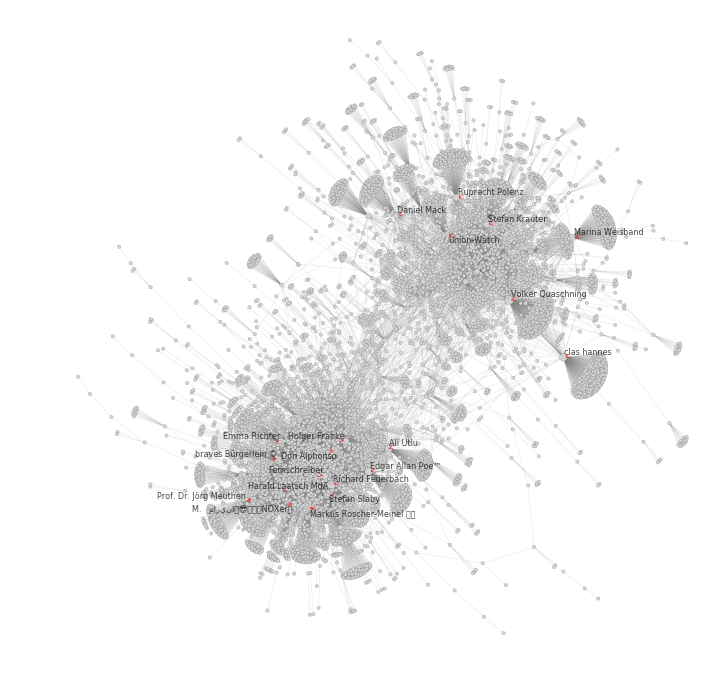

In [35]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, g, ig_layout, labels[:20])

plt.savefig('plots/rt_network.png')

plt.show()